Goal: try to match / cross-reference the CF names (`CF_Name_En`) in CF boundary data `All_CF_Cambodia_July_2016_DISES_v1.shp` and the village names in `CDB Nat Data 2016 En_Received Dec2017_230207_Reem.xlsx`.

This notebook enriches the CF data (with match helper in CSV format instead of the shapefile) with the CDB villages (names and IDs) in the commune each CF belongs to.

In a second section, this notebook trys to match / cross-reference the CF names in the CF boundary data `All_CF_Cambodia_July_2016_DISES_v1.shp` to the village names in the CDB village shapefile `Villages.shp`.

## setup

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from pathlib import Path

In [2]:
from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)

<IPython.core.display.Javascript object>

In [3]:
code_path = Path().absolute()
datafd_path = code_path.parent.parent / 'data'
intmd_outfd_path = code_path.parent.parent / 'output_intmd' / 'match_CF_CDB'
outfd_path = code_path.parent.parent / 'output' / 'data'

## read in data

### CDB socio-economic data, Reem updated 20230207


In [5]:
CDB_path = datafd_path / 'other' / 'CDB Nat Data 2016 En_Received Dec2017_230207_Reem.xlsx'
# CDB_df_dic = pd.read_excel(CDB_path, sheet_name=None)  # all sheets, key=sheet name
CDB_df_dic = pd.read_excel(CDB_path, sheet_name=['V_2016_E(1)', 'V_2016_E(2)', 'V_2016_E(3)'])
sht_name_lst = list(CDB_df_dic.keys())
# sheet names: ['Q_2016_E', 'V_2016_E(1)', 'V_2016_E(2)', 'V_2016_E(3)', 'C_2016_E(1)', 'C_2016_E(2)', 'D_2016_E(1)']

##### village-level CDB data

In [192]:
vill_sht_name_lst = [sht for sht in sht_name_lst if sht.startswith('V') ]
CDB_v_df_lst = [CDB_df_dic[sht] for sht in vill_sht_name_lst]

### CF data with match helper

In [147]:
CF_path = intmd_outfd_path / 'CF_w_match_helper.csv'
CF_df = pd.read_csv(CF_path)

### CF boundary data, updated in 20220526 email

In [4]:
CF_path = datafd_path / 'CF' / 'Cambodia' / \
    'All_CF_Cambodia_July_2016_DISES_v1' / \
    'All_CF_Cambodia_July_2016_DISES_v1.shp'
CF_gdf = gpd.read_file(CF_path)  # EPSG:3148

### CDB village shapefile

In [5]:
CDB_vill_shp_path = datafd_path / 'boundaries' / 'Cambodia_Admin-2015' / 'Villages.shp'
CDB_vill_gdf = gpd.read_file(CDB_vill_shp_path)  # EPSG:32648

### CF data with CDB village points (within 3km) matched 

In [94]:
CF_CDB_path = intmd_outfd_path / 'CF_w_vill_in_3km_matched.csv'
CF_CDB_df = pd.read_csv(CF_CDB_path)

## explore data

### CF

#### confirm csv has all info in shp

In [61]:
CF_collst = CF_gdf.columns[:-1]  # non-geometry columns

In [62]:
CF_gdf_df = pd.DataFrame(CF_gdf.sort_values('UniqueID'))[CF_collst]
CF_df2 = CF_df.sort_values('UniqueID')[CF_collst]

In [63]:
CF_gdf_df.shape == CF_df2.shape

True

In [47]:
CF_gdf_df.compare(CF_df2)  # just some rounding issues?

Date_Agree           HECTARES             
          self other         self        other
1          NaN   NaN    27.891450    27.891450
4          NaN   NaN   360.457135   360.457135
6          NaN   NaN   314.670963   314.670963
7          NaN   NaN   309.646478   309.646478
9          NaN   NaN   315.528175   315.528175
..         ...   ...          ...          ...
633        NaN   NaN   678.243093   678.243093
634        NaN   NaN  1323.423754  1323.423754
635        NaN   NaN   865.962900   865.962900
636        NaN   NaN   496.667300   496.667300
637        NaN   NaN  1367.360726  1367.360726

[496 rows x 4 columns]

#### explore key columns for joining

In [50]:
CF_df.columns

Index(['CF_Code', 'Code_Srok', 'Code_Khum', 'No_Village', 'CF_Name_En',
       'CF_Name_Kh', 'Villag_CDB', 'CF_Name_Note', 'Commune', 'Khum',
       'Commun_CDB', 'Commu_Note', 'District', 'Srok', 'Distri_CDB',
       'Distr_Note', 'Province', 'Division', 'Date_Praka', 'No_Prakas',
       'Date_Agree', 'Remarks', 'Code_CF', 'HECTARES', 'Yea_Agreem',
       'Agreement', 'NCF_statis', 'Year_CFMP', 'FA_Can', 'UniqueID',
       'Why_Remove', 'Overlap_Pa', 'geometry', 'Comm_Miss', 'Dist_Miss',
       'Comm_Match_CDB', 'Dist_Match_CDB', 'Comm_Uniq_CF', 'Comm_Uniq_CDB',
       'Dist_Uniq_CF', 'CF_Match', 'CommORDist', 'CoORDiOR2'],
      dtype='object')

In [52]:
CF_df.isnull().sum()  # no missing Commu_Note / Distr_Note 

CF_Code             0
Code_Srok           0
Code_Khum           0
No_Village          0
CF_Name_En          0
CF_Name_Kh          3
Villag_CDB        637
CF_Name_Note      599
Commune            28
Khum               72
Commun_CDB        265
Commu_Note          0
District           32
Srok              124
Distri_CDB        359
Distr_Note          0
Province            1
Division          440
Date_Praka         18
No_Prakas           0
Date_Agree        253
Remarks           506
Code_CF             0
HECTARES            0
Yea_Agreem          0
Agreement         237
NCF_statis        124
Year_CFMP           0
FA_Can            594
UniqueID            0
Why_Remove        601
Overlap_Pa          0
geometry            0
Comm_Miss           0
Dist_Miss           0
Comm_Match_CDB      0
Dist_Match_CDB      0
Comm_Uniq_CF        0
Comm_Uniq_CDB       0
Dist_Uniq_CF        0
CF_Match            0
CommORDist          0
CoORDiOR2           0
dtype: int64

In [53]:
CF_df.Commu_Note.value_counts()

updated to match with CDB              372
matches with CDB                       227
missing                                 27
no match in CDB                         11
updated to match with CDB, inferred      2
Name: Commu_Note, dtype: int64

In [54]:
CF_df.Distr_Note.value_counts()

matches with CDB                                                                        282
updated to match with CDB                                                               261
NA because commune name uniquely identifies the commune in both this dataset and CDB     51
missing                                                                                  26
updated to match with CDB, inferred                                                      18
no match in CDB                                                                           1
Name: Distr_Note, dtype: int64

In [163]:
CF_df[['Commu_Note', 'Distr_Note']].value_counts()#.sort_index()

Commu_Note                           Distr_Note                                                                          
updated to match with CDB            updated to match with CDB                                                               210
                                     matches with CDB                                                                        146
matches with CDB                     matches with CDB                                                                        132
                                     NA because commune name uniquely identifies the commune in both this dataset and CDB     51
                                     updated to match with CDB                                                                42
missing                              missing                                                                                  25
updated to match with CDB            updated to match with CDB, inferred                                                      16
no match in CDB                      updated to match with CDB                                                                 6
                                     matches with CDB                                                                          3
matches with CDB                     updated to match with CDB, inferred                                                       2
updated to match with CDB, inferred  updated to match with CDB                                                                 2
missing                              matches with CDB                                                                          1
                                     updated to match with CDB                                                                 1
no match in CDB                      missing                                                                                   1
                                     no match in CDB                                                                           1
dtype: int64

### CDB village shapefile

In [48]:
CDB_vill_gdf.PHUMCODE[CDB_vill_gdf.PHUMCODE.duplicated()]

13968    0
13969    0
Name: PHUMCODE, dtype: int64

## preprocess data: section 2

In [12]:
CDB_vill_proj_gdf = CDB_vill_gdf.to_crs(CF_gdf.crs)

### check projection

In [15]:
import matplotlib.pyplot as plt

<AxesSubplot:>

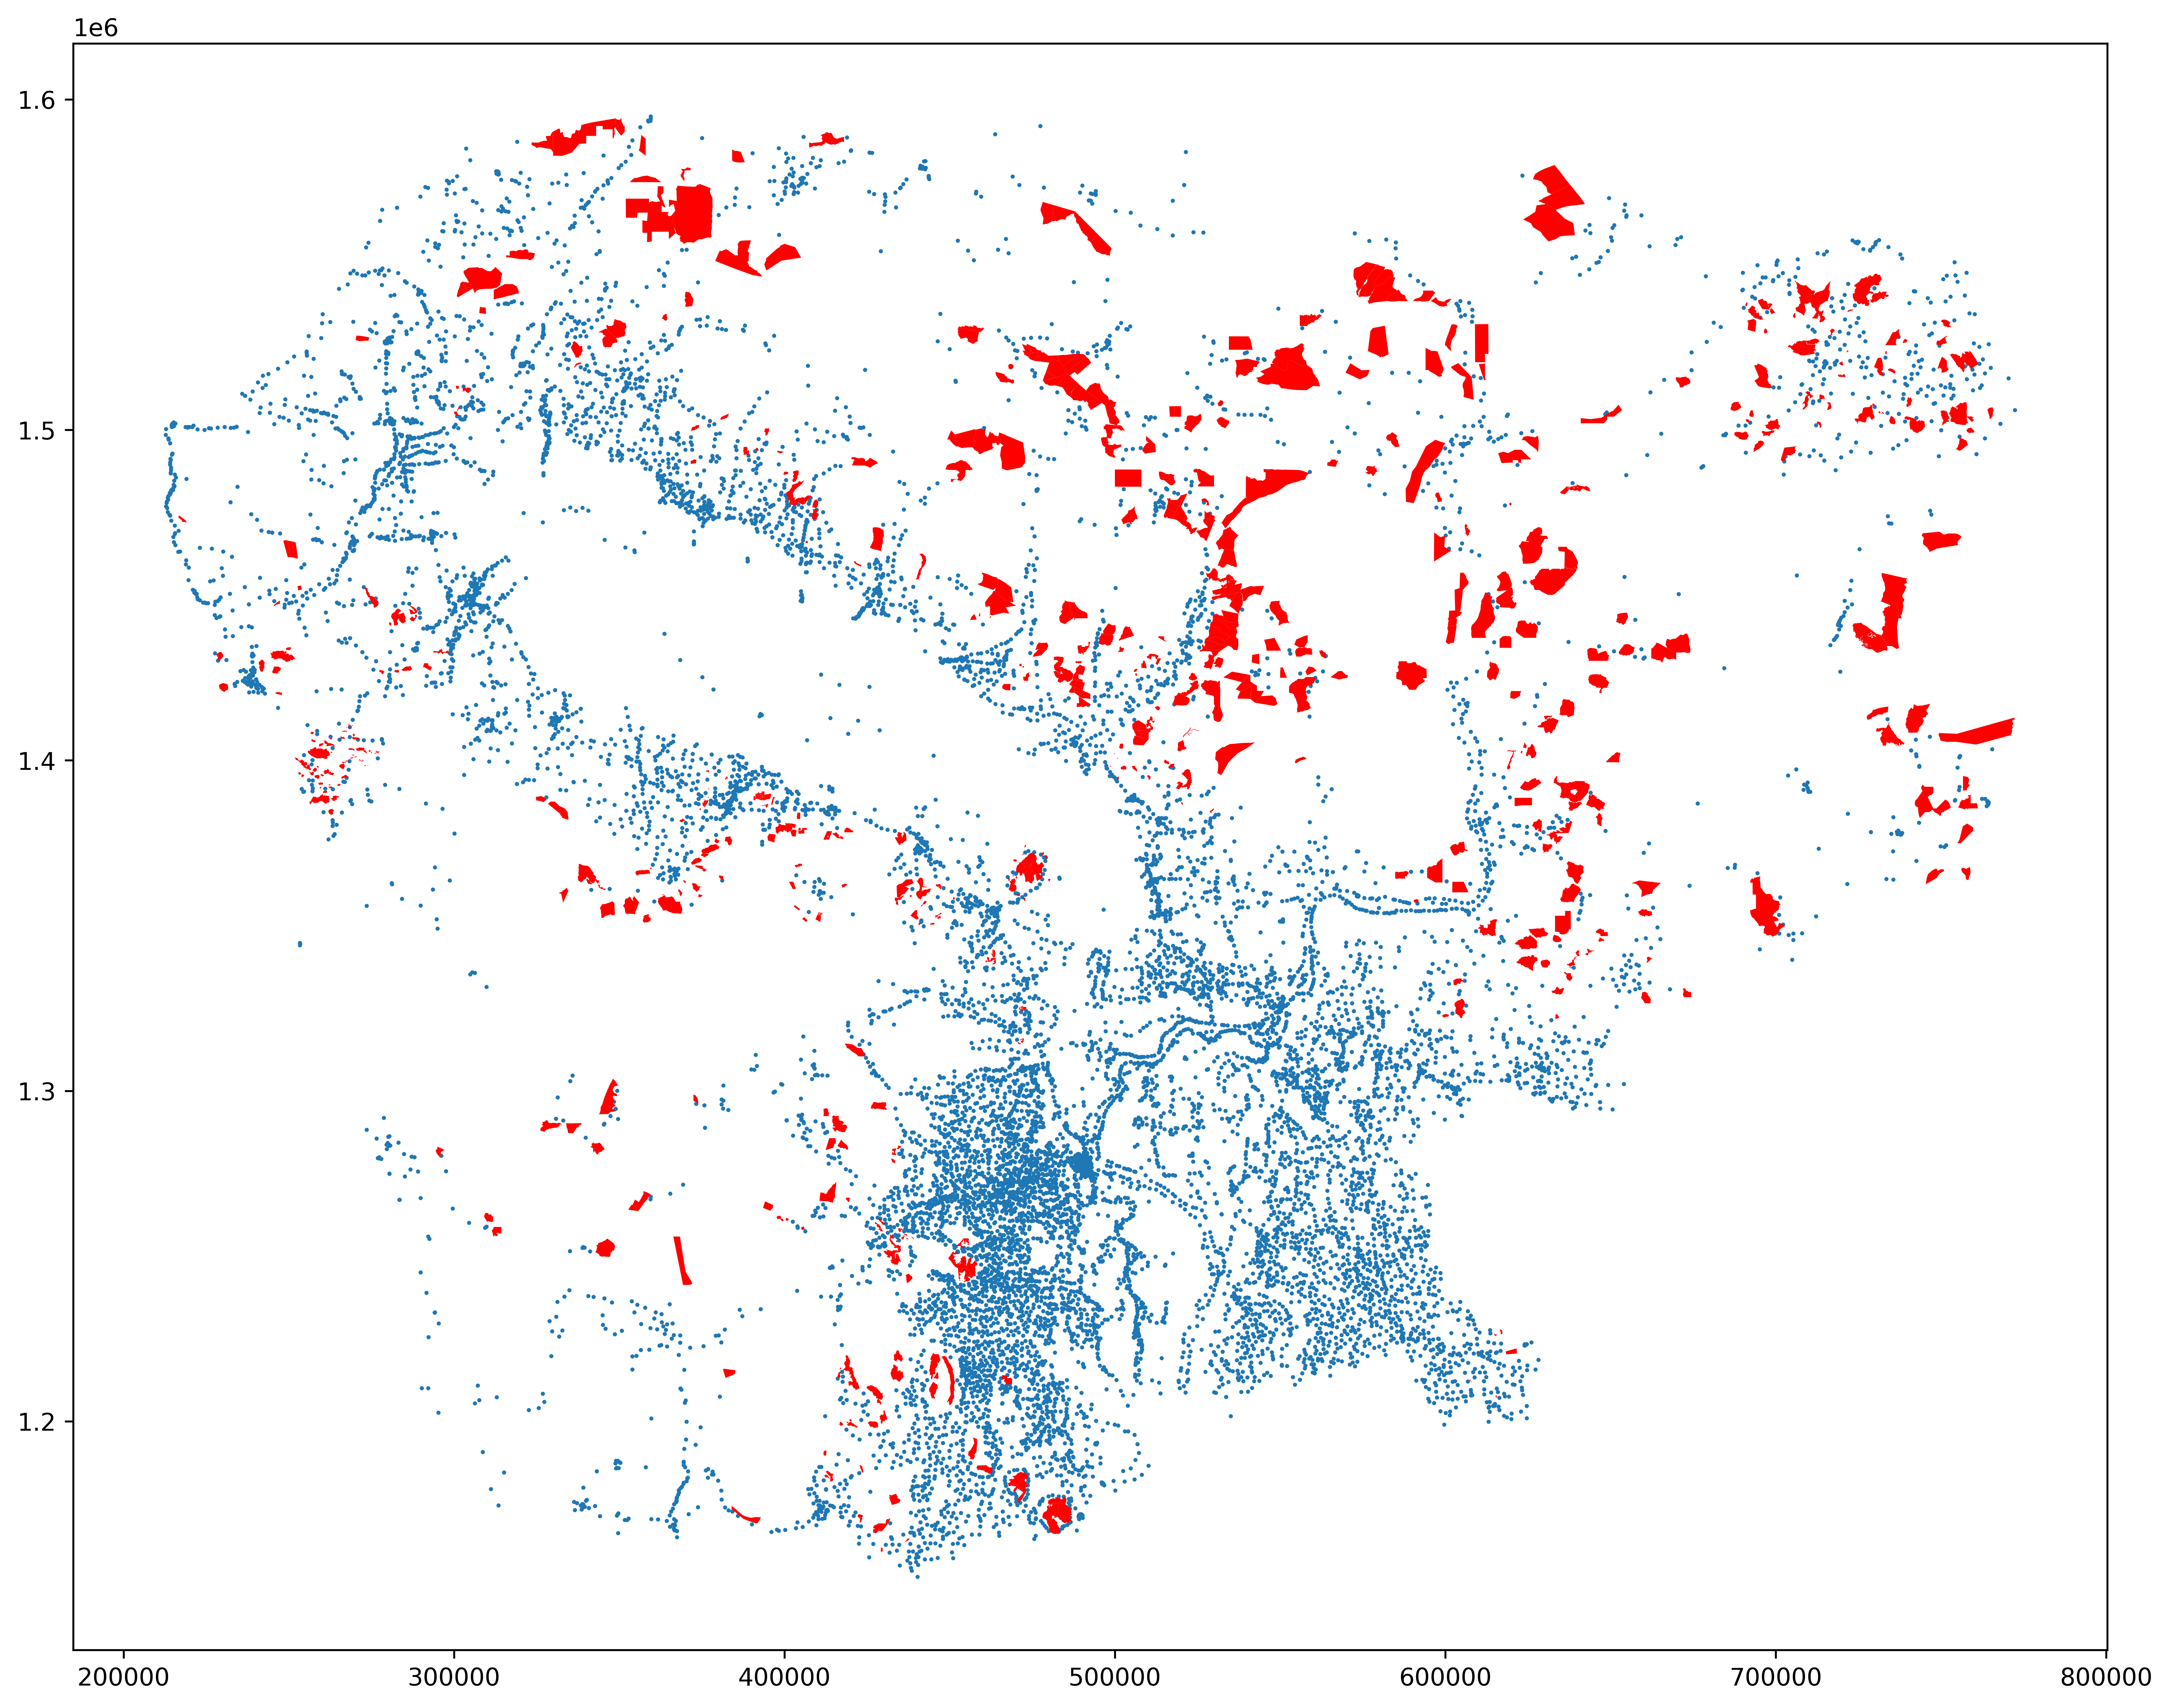

In [27]:
fig, ax = plt.subplots(figsize=(15, 15), dpi=600)
CDB_vill_proj_gdf.plot(ax=ax, markersize=.5)
CF_gdf.plot(ax=ax, color='red')

## preprocess data

### CF data with match helper

#### consolidate commune and district name columns for joining, using match helper info

In [148]:
def append_CDB_comm_dist(helper_s):
    '''Appends CDB commune and district names'''
    comm_CF, dist_CF, comm_note, dist_note, comm_CDB, dist_CDB = helper_s[
        ['Commune', 'District', 'Commu_Note', 'Distr_Note', 'Commun_CDB', 'Distri_CDB']
    ]

    if comm_note == 'matches with CDB':
        comm = comm_CF
        if dist_note == 'NA because commune name uniquely identifies the commune in both this dataset and CDB':
            dist = 'NA'
        elif dist_note == 'matches with CDB':
            dist = dist_CF
        elif dist_note.startswith('updated to match with CDB'):
            dist = dist_CDB
        else:
            print(f'Distr_Note not handled: {dist_note}')
    elif comm_note.startswith('updated to match with CDB'):
        comm = comm_CDB
        if dist_note == 'matches with CDB':
            dist = dist_CF
        elif dist_note.startswith('updated to match with CDB'):
            dist = dist_CDB
        else:
            print(f'Distr_Note not handled: {dist_note}')
    elif comm_note == 'no match in CDB':
        comm = np.nan
        if dist_note == 'matches with CDB':
            dist = dist_CF
        elif dist_note.startswith('updated to match with CDB'):
            dist = dist_CDB
        elif dist_note in ['missing', 'no match in CDB']:
            dist = np.nan
        else:
            print(f'Distr_Note not handled: {dist_note}')
    elif comm_note == 'missing':
        comm = np.nan
        if dist_note == 'matches with CDB':
            dist = dist_CF
        elif dist_note.startswith('updated to match with CDB'):
            dist = dist_CDB
        elif dist_note in ['missing', 'no match in CDB']:
            dist = np.nan
        else:
            print(f'Distr_Note not handled: {dist_note}')
    else:
        print(f'Commun_Note not handled: {comm_note}')
        
    helper_s['Commune_matched'] = comm
    helper_s['District_matched'] = dist
    return helper_s

In [149]:
CF_matched_df = CF_df.apply(
    append_CDB_comm_dist,
    axis=1
)

#### explore consolidated data

In [150]:
(CF_matched_df['Commune_matched'] == CF_matched_df['Commune']).sum()

228

In [160]:
CF_matched_df[
    (CF_matched_df['Commune_matched'] == CF_matched_df['Commune']) & \
    (CF_matched_df['Commu_Note'] != 'matches with CDB')
]
# Commune matches with CDB, but noted as updated to match with CDB
# ok since "updated" name is in Commun_CDB

CF_Code  Code_Srok  Code_Khum  No_Village  CF_Name_En CF_Name_Kh  \
255        0          0          0           0  Phnom Meas     PñMmas   

    Villag_CDB CF_Name_Note Commune Khum  ... Comm_Match_CDB Dist_Match_CDB  \
255        NaN          NaN   Thmei  fµI  ...              1              0   

    Comm_Uniq_CF Comm_Uniq_CDB Dist_Uniq_CF CF_Match CommORDist CoORDiOR2  \
255            1             0            0    False      False     False   

    Commune_matched  District_matched  
255           Thmei       Chetr Borei  

[1 rows x 45 columns]

In [162]:
(CF_matched_df['Commune_matched'] == CF_matched_df['Commun_CDB']).sum()

374

In [164]:
CF_matched_df[
    (CF_matched_df['Commune_matched'] == CF_matched_df['Commun_CDB']) & \
    (CF_matched_df['Commu_Note'] != 'updated to match with CDB')
]
# updated to match with CDB, INFERRED

CF_Code  Code_Srok  Code_Khum  No_Village         CF_Name_En  \
35     20922        209      20903           0  Potential Area 21   
287        0          0          0           0            Sampong   

            CF_Name_Kh Villag_CDB                         CF_Name_Note  \
35   tMbn;skþanuBlTI21        NaN                                  NaN   
287              sMBug        NaN  not a village in the commune in CDB   

      Commune     Khum  ... Comm_Match_CDB Dist_Match_CDB Comm_Uniq_CF  \
35     Samrel    sMril  ...              0              0            1   
287  Koh Knhe  ekaHExJ  ...              0              0            1   

    Comm_Uniq_CDB Dist_Uniq_CF CF_Match CommORDist CoORDiOR2 Commune_matched  \
35              1            0    False      False     False       Ou Samril   
287             1            0     True      False     False    Kaoh Khnhaer   

     District_matched  
35            Samlout  
287           Sambour  

[2 rows x 45 columns]

In [168]:
(CF_matched_df['District_matched'] == CF_matched_df['District']).sum()

282

In [170]:
(CF_matched_df['District_matched'] == CF_matched_df['Distri_CDB']).sum()

279

#### strip leading/trailing spaces and convert to lower case

In [171]:
for col in ['District', 'Commune']:
    CF_matched_df[f'{col}_cln'] = CF_matched_df[f'{col}_matched'].astype(str).str.strip().str.lower()

#### explore cleaned data

In [184]:
CF_matched_df.loc[:, CF_matched_df.columns.str.startswith('Commune')]

Commune Commune_matched     Commune_cln
0          Poy Char        Poy Char        poy char
1        Chub Veary      Chob Veari      chob veari
2        Chub Veary      Chob Veari      chob veari
3        Chub Veary      Chob Veari      chob veari
4        Chub Veary      Chob Veari      chob veari
..              ...             ...             ...
634  Trapeang Pring  Trapeang Pring  trapeang pring
635  Trapeang Pring  Trapeang Pring  trapeang pring
636  Trapeang Pring  Trapeang Pring  trapeang pring
637  Trapeang Pring  Trapeang Pring  trapeang pring
638          Samaki        Sameakki        sameakki

[639 rows x 3 columns]

In [183]:
CF_matched_df.loc[:, CF_matched_df.columns.str.startswith('District')]

District  District_matched      District_cln
0         Phnom Srok                NA                na
1    Preah Netrpreah  Preah Netr Preah  preah netr preah
2    Preah Netrpreah  Preah Netr Preah  preah netr preah
3    Preah Netrpreah  Preah Netr Preah  preah netr preah
4    Preah Netrpreah  Preah Netr Preah  preah netr preah
..               ...               ...               ...
634           Dambae            Dambae            dambae
635           Dambae            Dambae            dambae
636           Dambae            Dambae            dambae
637           Dambae            Dambae            dambae
638          Ou Chum           Ou Chum           ou chum

[639 rows x 3 columns]

In [211]:
CF_matched_df[CF_matched_df.District_cln == 'na']  # Distr_Note == 'NA because commune name uniquely identifies the commune in both this dataset and CDB'

CF_Code  Code_Srok  Code_Khum  No_Village  \
0      10301        103      10302           3   
29     20607        206      20612           5   
30     20608        206      20612           5   
58     40102        401      40111           0   
59     40103        401      40111           0   
71     40615        406      40602           0   
72     40617        406      40602           0   
73     40616        406      40602           0   
91     50302        503      50311           0   
92     50303        503      50311           0   
95     50406        504      50404           0   
100    50609        506      50602           0   
101    50610        506      50602           0   
102        0          0          0           0   
109        0          0          0           0   
128        0          0          0           0   
129        0          0          0           0   
130        0          0          0           0   
160    60527        605      60504           1   
161    60528        605      60504           1   
162    60529        605      60504           1   
211    60310        603      60311           1   
237        0          0          0           0   
274   100304       1003     100303           4   
279        0          0          0           0   
280        0          0          0           0   
281        0          0          0           0   
282        0          0          0           0   
283        0          0          0           0   
284        0          0          0           0   
285        0          0          0           0   
286        0          0          0           0   
291        0          0          0           0   
300   100414       1004     100409           4   
323   110306       1103     110301           0   
324   110307       1103     110301           1   
325   110305       1103     110301           1   
350   220409       2204     220403           2   
351   220410       2204     220403           1   
352   220411       2204     220403           1   
487   150433       1504     150405           1   
510   160306       1607     160306           0   
557   170305       1703     170301           1   
565   170413       1704     170411           2   
578   171125       1711     171107           7   
579   171126       1711     171107           1   
583   171232       1712     171201           1   
584   171231       1712     171201           1   
585   171234       1712     171206           1   
586   171235       1712     171206           1   
609        0          0          0           0   

                           CF_Name_En                CF_Name_Kh Villag_CDB  \
0                        Kon Khleaeng                   kUnExøg        NaN   
29                        Phnom Roung                    PñMrUg        NaN   
30                       Prey Tralach                  éRBRtLac        NaN   
58           185 K Thida Chambak Thom        185 ka FItacMbk;FM        NaN   
59                 Phum Trapeang Chan            PUmiRtBaMgcan;        NaN   
71                       Phum O Leach                PUmiGUrlaC        NaN   
72                   Phum Russeiduoch              PUmib¤sSIdYc        NaN   
73                Phum Trapeang Pkoam            PUmiRtBaMgpÁaM        NaN   
91                        Phnom Srang                   PñMRsg;        NaN   
92                       Changor Toch                 ceg¥artUc        NaN   
95                        O Prean Mok                 GUrRBanmk        NaN   
100                      Kroch Bourng                   RkUcbYg        NaN   
101                    Chruos Dambong                 eRCaHdMbg        NaN   
102                     Chrosh Pongro                   RCYsBRg        NaN   
109                       Chrous Svay                  RCYssVay        NaN   
128                           Ou Saom                   GUresam        NaN   
129                     Bos Yeay Nheb                busSyayejb        NaN   


### CDB

#### fix headers of village-level CDB data

In [193]:
CDB_v_df_lst = [df.rename(columns=df.iloc[3]).tail(-4) for df in CDB_v_df_lst]

#### join 3 village sheets

In [194]:
CDB_v_df = pd.concat(CDB_v_df_lst, axis=1)

#### select columns in CDB

In [195]:
CDB_v_df = CDB_v_df.iloc[:, :5]

#### explore commune and district name columns for joining

In [197]:
CDB_v_df.isnull().sum()  # no missing

VillGis     0
Province    0
District    0
Commune     0
Village     0
dtype: int64

#### strip leading/trailing spaces and convert to lower case

In [199]:
for col in ['Province', 'District', 'Commune', 'Village']:
    CDB_v_df[f'{col}_cln'] = CDB_v_df[col].astype(str).str.strip().str.lower()

#### explore commune and district name columns for joining

In [176]:
CDB_v_df.isnull().sum()  # no missing

VillGis         0
Province        0
District        0
Commune         0
Village         0
Province_cln    0
District_cln    0
Commune_cln     0
Village_cln     0
dtype: int64

## Section 2: enrich the CF data with CDB villages within 5km an 3km

### spatial join

In [71]:
CF_gdf['geometry_5km'] = CF_gdf.buffer(5000)
CF_gdf['geometry_3km'] = CF_gdf.buffer(3000)
CF_5km_gdf = CF_gdf.set_geometry('geometry_5km')
CF_3km_gdf = CF_gdf.set_geometry('geometry_3km')

In [72]:
CF_villIn5km_gdf = CF_5km_gdf.sjoin(
    CDB_vill_proj_gdf, how='left', predicate='contains'
)
CF_villIn3km_gdf = CF_3km_gdf.sjoin(
    CDB_vill_proj_gdf, how='left', predicate='contains'
)

### aggregate

#### 5km vs 3km

In [65]:
# 57 CFs have 0 villages withint 5km
CF_villIn5km_gdf.groupby(['UniqueID'])['PHUMCODE'].count().value_counts().sort_index()

0      57
1      66
2      54
3      48
4      38
5      52
6      29
7      39
8      28
9      30
10     18
11     14
12     20
13     11
14      9
15     16
16      3
17      2
18      5
19      4
20      4
21     11
22      6
23      7
24      5
26      6
27      7
28      7
29      2
30      7
31      5
32      4
33      7
34      2
35      1
37      3
38      3
40      1
41      1
42      1
45      1
53      1
58      1
62      1
77      1
107     1
Name: PHUMCODE, dtype: int64

<AxesSubplot:>

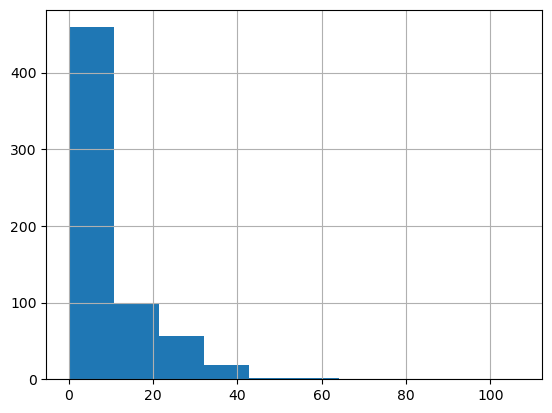

In [76]:
CF_villIn5km_gdf.groupby(['UniqueID'])['PHUMCODE'].count().hist()

In [74]:
# 147 CFs have 0 villages withint 3km
CF_villIn3km_gdf.groupby(['UniqueID'])['PHUMCODE'].count().value_counts().sort_index()

0     147
1     113
2     104
3      65
4      42
5      42
6      24
7      13
8      14
9      14
10      8
11      5
12      8
13      7
14      7
15      7
16      4
17      1
18      3
19      2
21      1
23      2
24      2
28      1
30      1
32      1
46      1
Name: PHUMCODE, dtype: int64

<AxesSubplot:>

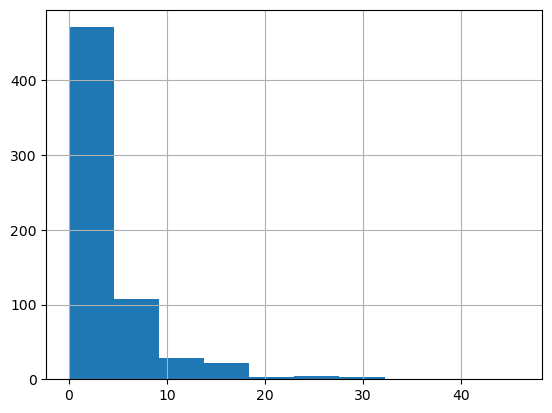

In [77]:
CF_villIn3km_gdf.groupby(['UniqueID'])['PHUMCODE'].count().hist()

#### aggregate

In [86]:
CFID_villIn3kmLst_gdf = CF_villIn3km_gdf.groupby(['UniqueID']).agg(
    {
        var: lambda x: '\n'.join(x.astype(str)) for var in ['VILLAGE', 'PHUMCODE']
    }  # concatenate all village names in the commune with \n as delimiter, same for village IDs
)

### enrich

In [89]:
# enrich the CF data with the concatenated village names and IDs
CF_villIn3kmLst_gdf = CF_gdf.merge(
    CFID_villIn3kmLst_gdf,
    how='inner',
    on='UniqueID',
    validate='1:1'
)

## enrich the CF data with the CDB villages in the commune each CF belongs to

### join

In [212]:
# split CFs based on if the commune can/cannot uniquely identify a record in
# the 2 datasets to be joined
CF_dup_comm_df = CF_matched_df[CF_matched_df['District_cln'] != 'na']
CF_uniq_comm_df = CF_matched_df[CF_matched_df['District_cln'] == 'na']  # Distr_Note == 'NA because commune name uniquely identifies the commune in both this dataset and CDB'

In [216]:
# if not unique, join based on commune + district
CF_villInComm_df1 = CF_dup_comm_df.merge(
    CDB_v_df,
    how='left',
    on=['District_cln', 'Commune_cln'],
    suffixes=(None, '_CDB'),
    indicator=True
)
# if unique, join based on commune
CF_villInComm_df2 = CF_uniq_comm_df.merge(
    CDB_v_df,
    how='left',
    on=['Commune_cln'],
    suffixes=(None, '_CDB'),
    indicator=True
)

In [224]:
CF_villInComm_df2.drop(columns='District_cln_CDB', inplace=True)  # b/c not merged as in df1, 

In [229]:
CF_villInComm_df = pd.concat([CF_villInComm_df1, CF_villInComm_df2])

#### explore joined data

In [218]:
CF_villInComm_df1._merge.value_counts()  # 47 could not join

both          4532
left_only       47
right_only       0
Name: _merge, dtype: int64

In [220]:
CF_villInComm_df2._merge.value_counts()  # all joined!

both          491
left_only       0
right_only      0
Name: _merge, dtype: int64

In [221]:
CF_villInComm_df1[CF_villInComm_df1._merge == 'left_only'].Province.value_counts()
# 7/47 in focal provinces

Takeo            13
Mundulkiri       10
Kratie            6
Battambong        4
Pailin            3
Pursat            3
Ratanaki Kiri     3
Kampot            2
Kampong Thom      1
Koh Kong          1
Svay Rieng        1
Name: Province, dtype: int64

In [230]:
CF_villInComm_df.shape

(5070, 55)

In [231]:
CF_villInComm_df

CF_Code  Code_Srok  Code_Khum  No_Village        CF_Name_En  CF_Name_Kh  \
0      10405        104      10402           2  Phnom Chuncheang  PMñCBa¢aMg   
1      10405        104      10402           2  Phnom Chuncheang  PMñCBa¢aMg   
2      10405        104      10402           2  Phnom Chuncheang  PMñCBa¢aMg   
3      10405        104      10402           2  Phnom Chuncheang  PMñCBa¢aMg   
4      10405        104      10402           2  Phnom Chuncheang  PMñCBa¢aMg   
..       ...        ...        ...         ...               ...         ...   
486   171235       1712     171206           1      Slaeng Spean    Esøgs<an   
487   171235       1712     171206           1      Slaeng Spean    Esøgs<an   
488        0          0          0           0       Kiri Soksan  KirIsuxsan   
489        0          0          0           0       Kiri Soksan  KirIsuxsan   
490        0          0          0           0       Kiri Soksan  KirIsuxsan   

    Villag_CDB CF_Name_Note       Commune      Khum  ...      District_cln  \
0          NaN          NaN    Chub Veary   Cb;varI  ...  preah netr preah   
1          NaN          NaN    Chub Veary   Cb;varI  ...  preah netr preah   
2          NaN          NaN    Chub Veary   Cb;varI  ...  preah netr preah   
3          NaN          NaN    Chub Veary   Cb;varI  ...  preah netr preah   
4          NaN          NaN    Chub Veary   Cb;varI  ...  preah netr preah   
..         ...          ...           ...       ...  ...               ...   
486        NaN          NaN  Slaeng Spean  Esøgs<an  ...                na   
487        NaN          NaN  Slaeng Spean  Esøgs<an  ...                na   
488        NaN          NaN  Anlong Chrey       NaN  ...                na   
489        NaN          NaN  Anlong Chrey       NaN  ...                na   
490        NaN          NaN  Anlong Chrey       NaN  ...                na   

      Commune_cln   VillGis      Province_CDB      District_CDB   Commune_CDB  \
0      chob veari   1040201  Banteay Meanchey  Preah Netr Preah    Chob Veari   
1      chob veari   1040202  Banteay Meanchey  Preah Netr Preah    Chob Veari   
2      chob veari   1040203  Banteay Meanchey  Preah Netr Preah    Chob Veari   
3      chob veari   1040204  Banteay Meanchey  Preah Netr Preah    Chob Veari   
4      chob veari   1040205  Banteay Meanchey  Preah Netr Preah    Chob Veari   
..            ...       ...               ...               ...           ...   
486  slaeng spean  17120613         Siem Reap         Srei Snam  Slaeng Spean   
487  slaeng spean  17120614         Siem Reap         Srei Snam  Slaeng Spean   
488  anlong chrey  19050501       Stung Treng     Thala Barivat  Anlong Chrey   
489  anlong chrey  19050502       Stung Treng     Thala Barivat  Anlong Chrey   
490  anlong chrey  19050503       Stung Treng     Thala Barivat  Anlong Chrey   

           Village      Province_cln    Village_cln  _merge  
0             Chob  banteay meanchey           chob    both  
1       Roul Chruk  banteay meanchey     roul chruk    both  
2           Prasat  banteay meanchey         prasat    both  
3    Krasang Thmei  banteay meanchey  krasang thmei    both  
4           Pradak  banteay meanchey         pradak    both  
..             ...               ...            ...     ...  
486       Dang Kor         siem reap       dang kor    both  
487           Leib         siem reap           leib    both  
488   Anlong Chrey       stung treng   anlong chrey    both  
489            Man       stung treng            man    both  
490         Sralao       stung treng         sralao    both  

[5070 rows x 55 columns]

### aggregate

In [236]:
CF_villInComm_df.groupby(['UniqueID'])['Commune_CDB'].nunique().value_counts()
# 592 CFs have 1 unique commune associated with them

1    592
0     47
Name: Commune_CDB, dtype: int64

In [246]:
# aggregate from village-level to commune-level
CFID_villInCommLst_df = CF_villInComm_df.groupby(['UniqueID']).agg(
    {
        var: lambda x: '\n'.join(x.astype(str)) for var in ['Village', 'VillGis']
    }  # concatenate all village names in the commune with \n as delimiter, same for village IDs
)

### enrich

In [250]:
# enrich the CF data with the concatenated village names and IDs
CF_villInCommLst_df = CF_matched_df.merge(
    CFID_villInCommLst_df,
    how='inner',
    on='UniqueID',
    validate='1:1'
)

## export data

In [252]:
# CF_villInCommLst_df.to_csv(intmd_outfd_path / 'CF_w_match_helper_vill.csv', index=False)

### Section 2

In [91]:
# CF_villIn3kmLst_gdf.to_csv(intmd_outfd_path / 'CF_w_vill_in_3km.csv', index=False)

## Section 2: join back to the CF boundary data, the CF data with CDB village points matched 

In [113]:
CF_w_CDB_vill_in_3km_gdf = CF_gdf.merge(
    CF_CDB_df[
        ['UniqueID'] + list(CF_CDB_df.columns[-4:])
    ],
    how='left',
    on='UniqueID',
    indicator=False,
    validate='1:1'
)

In [114]:
CF_w_CDB_vill_in_3km_gdf[['VILLAGE','PHUMCODE','vill_match']] = \
CF_w_CDB_vill_in_3km_gdf[['VILLAGE','PHUMCODE','vill_match']].replace('\n', ',', regex=True)

In [115]:
CF_w_CDB_vill_in_3km_gdf.drop(columns=['geometry_5km', 'geometry_3km'], inplace=True)

In [117]:
# write to a shapefile
CF_w_CDB_vill_in_3km_gdf.to_file(
    outfd_path / 'CF_w_CDB_village_in_3km' / 'CF_w_CDB_village_in_3km.shp',
    encoding='utf-8'
)

### export to spreadsheet format too

In [4]:
CF_w_CDB_vill_in_3km_gdf = gpd.read_file(
    outfd_path / 'CF_w_CDB_village_in_3km' / 'CF_w_CDB_village_in_3km.shp',
    encoding='utf-8'
)

In [4]:
CF_w_CDB_vill_in_3km_gdf = gpd.read_file(
    outfd_path / 'CF_w_CDB_village_in_3km' / 'CF_w_CDB_village_in_3km.shp',
    encoding='utf-8'
)

In [6]:
from shapely import wkt

In [9]:
CF_w_CDB_vill_in_3km_gdf['geom_wkt'] = CF_w_CDB_vill_in_3km_gdf.geometry.apply(lambda x: x.wkt)

In [12]:
CF_w_CDB_vill_in_3km_gdf.drop(columns='geometry', inplace=True)

In [14]:
CF_w_CDB_vill_in_3km_gdf.to_csv(outfd_path/'CF_w_CDB_village_in_3km.csv', index=False)